# Parallel Coordinates Plots

### Introduction

Parallel coordinates plots (also known as parallel axis plots) are a common way to visualize many-dimensional data. There are many different tools that can be used to create parallel coordinates plots in Python. For example, Pandas has a built-in version, as demonstrated in the [MOEA Diagnostics page](https://reedgroup.github.io/FigureLibrary/MOEADiagnostics.html) of this manual. There are also many different posts on the Water Programming Blog that demonstrate different ways to create parallel coordinates plots in Python as well as several GUI-based visualization engines (e.g., [Lau 2020](https://waterprogramming.wordpress.com/2020/11/09/parallel-axis-plots-for-the-absolute-beginner/), [Lau 2022](https://waterprogramming.wordpress.com/2022/09/14/fisheries-training-part-2-tradeoff-visualization-and-introduction-to-j3/), [Dircks 2020](https://waterprogramming.wordpress.com/2020/08/10/using-rhodium-for-exploratory-modeling/), [Trindade 2018](https://waterprogramming.wordpress.com/2018/05/18/creating-parallel-axis-plots-with-multiple-datasets-color-gradients-and-brushing-in-python/), [Gupta 2018](https://waterprogramming.wordpress.com/2018/11/05/introduction-to-discoverydv/), and more).

So why the need for yet another page on parallel coordinates plots? In my experience, the pre-packaged functions for creating these plots (e.g., Pandas) are great for getting a quick-and-dirty look at the data, but they are insufficiently flexible to create more complex and aesthetically pleasing figures. When it comes time to create figures for papers and presentations, I have generally had to start from scratch to create a parallel coordinates plot that suits my particular needs at the time. I imagine this is true for many other researchers as well. This process can be tedious, especially when there is a need to create several distinct versions of a figure, such as when coloring along different axes, or when creating multiple "brushing" scenarios where solutions are filtered out based on satisficing criteria. 

Over the years, I have developed a set of functions for creating different types of parallel coordinates plots. The goal of this page is to present these functions with the hope that they will facilitate the creation of flexible and attractive parallel coordinates plots for other researchers. The functions below are capable of applying a range of customizations, such as:

1. Automatic normalization of data consistent with user-selected direction of preference for parallel axes ("top" or "bottom") and user-selected direction of optimization preference for each axis ("min" or "max")
2. Support for user-defined continuous or categorical color palettes, and choice of which variable to color lines by. Automated legend creation based on continuous or categorical palette.
3. Choice of which axis to order lines by (i.e., how to stack overlapping lines)
4. Automated solution brushing based on satisficing criteria for one or more axes.

My hope is that others will add to this over time as new use cases arise so that we can all benefit from improved flexibility & functionality and not have to reinvent the wheel each time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from pandas.plotting import parallel_coordinates

figsize = (11,6)
fontsize = 14
fig_dir = 'temp_figs/'

### Functions for flexible parallel coordinates plots

First, we need a function for reorganizing & normalizing the input data. This function takes the data as a Pandas DataFrame ("objs") as well as a list of column names corresponding to the subset of variables you want to plot ("column_axes") as parallel axes. In addition, "ideal_direction" gives the direction of preference for ideal performance ("top" or "bottom"), while "minmaxs" should be a list with the same length as "column_axes", with each element either "min" or "max". For variables labeled "max", the axis will be oriented with its maximum values pointing in the "ideal_direction", while variables labeled "min" will point in the opposite direction. After normalization, each column in the dataframe will scale from 0 (which maps to the bottom of the figure) to 1 (which maps to the top of the figure). This function returns the normalized dataframe "objs_reorg", as well as the lists "tops" and "bottoms" that store the numerical values corresponding to the top and bottom of each axis prior to normalization.

In [2]:
### function to normalize data based on direction of preference and whether each objective is minimized or maximized
###   -> output dataframe will have values ranging from 0 (which maps to bottom of figure) to 1 (which maps to top)
def reorganize_objs(objs, columns_axes, ideal_direction, minmaxs):
    ### if min/max directions not given for each axis, assume all should be maximized
    if minmaxs is None:
        minmaxs = ['max']*len(columns_axes)
        
    ### get subset of dataframe columns that will be shown as parallel axes
    objs_reorg = objs[columns_axes]
    
    ### reorganize & normalize data to go from 0 (bottom of figure) to 1 (top of figure), 
    ### based on direction of preference for figure and individual axes
    if ideal_direction == 'bottom':
        tops = objs_reorg.min(axis=0)
        bottoms = objs_reorg.max(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, -1] = (objs_reorg.iloc[:, -1] - objs_reorg.iloc[:, -1].min(axis=0)) / \
                                         (objs_reorg.iloc[:, -1].max(axis=0) - objs_reorg.iloc[:, -1].min(axis=0))
    elif ideal_direction == 'top':
        tops = objs_reorg.max(axis=0)
        bottoms = objs_reorg.min(axis=0)
        for i, minmax in enumerate(minmaxs):
            if minmax == 'max':
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i] - objs_reorg.iloc[:, i].min(axis=0)) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))
            else:
                bottoms[i], tops[i] = tops[i], bottoms[i]
                objs_reorg.iloc[:, i] = (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i]) / \
                                        (objs_reorg.iloc[:, i].max(axis=0) - objs_reorg.iloc[:, i].min(axis=0))

    return objs_reorg, tops, bottoms

The next function gets the color of a particular solution based on a user-defined color mapping (either continuous or categorical). 

In [3]:
### function to get color based on continuous color map or categorical map
def get_color(value, color_by_continuous, color_palette_continuous, 
              color_by_categorical, color_dict_categorical):
    if color_by_continuous is not None:
        color = colormaps.get_cmap(color_palette_continuous)(value)
    elif color_by_categorical is not None:
        color = color_dict_categorical[value]
    return color

Next, there is a function for getting the zorder parameter dictating a particular solution's order in the stacked plot. Plotted elements with larger zorder values will be stacked in the foreground of the plot, while elements with smaller zorder values will be further in the background and may be covered up. This function calculates the zorder for a solution by binning the normalized values for a user-defined axis into a discrete number of classes, in either ascending or descending order.

In [4]:
### function to get zorder value for ordering lines on plot. 
### This works by binning a given axis' values and mapping to discrete classes.
def get_zorder(norm_value, zorder_num_classes, zorder_direction):
    xgrid = np.arange(0, 1.001, 1/zorder_num_classes)
    if zorder_direction == 'ascending':
        return 4 + np.sum(norm_value > xgrid)
    elif zorder_direction == 'descending':
        return 4 + np.sum(norm_value < xgrid)
    
        

Lastly, here is the general function for creating flexible parallel coordinates plots. It has many optional arguments corresponding to user choices related to color palettes, direction of preference, brushing, aesthetics, etc. The use of these parameters will become clear in the examples in the next section.

In [5]:
### customizable parallel coordinates plot
def custom_parallel_coordinates(objs, columns_axes=None, axis_labels=None, 
                                ideal_direction='top', minmaxs=None, 
                                color_by_continuous=None, color_palette_continuous=None, 
                                color_by_categorical=None, color_palette_categorical=None,
                                colorbar_ticks_continuous=None, color_dict_categorical=None,
                                zorder_by=None, zorder_num_classes=10, zorder_direction='ascending', 
                                alpha_base=0.8, brushing_dict=None, alpha_brush=0.05, 
                                lw_base=1.5, fontsize=14, 
                                figsize=(11,6), save_fig_filename=None):
    
    ### verify that all inputs take supported values
    assert ideal_direction in ['top','bottom']
    assert zorder_direction in ['ascending', 'descending']
    if minmaxs is not None:
        for minmax in minmaxs:
            assert minmax in ['max','min']
    assert color_by_continuous is None or color_by_categorical is None
    if columns_axes is None:
        columns_axes = objs.columns
    if axis_labels is None:
        axis_labels = column_axes
    
    ### create figure
    fig,ax = plt.subplots(1,1,figsize=figsize, gridspec_kw={'hspace':0.1, 'wspace':0.1})

    ### reorganize & normalize objective data
    objs_reorg, tops, bottoms = reorganize_objs(objs, columns_axes, ideal_direction, minmaxs)

    ### apply any brushing criteria
    if brushing_dict is not None:
        satisfice = np.zeros(objs.shape[0]) == 0.
        ### iteratively apply all brushing criteria to get satisficing set of solutions
        for col_idx, (threshold, operator) in brushing_dict.items():
            if operator == '<':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] < threshold)
            elif operator == '<=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] <= threshold)
            elif operator == '>':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] > threshold)
            elif operator == '>=':
                satisfice = np.logical_and(satisfice, objs.iloc[:,col_idx] >= threshold)

            ### add rectangle patch to plot to represent brushing
            threshold_norm = (threshold - bottoms[col_idx]) / (tops[col_idx] - bottoms[col_idx])
            if ideal_direction == 'top' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
            elif ideal_direction == 'top' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            if ideal_direction == 'bottom' and minmaxs[col_idx] == 'max':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
            elif ideal_direction == 'bottom' and minmaxs[col_idx] == 'min':
                if operator in ['<', '<=']:
                    rect = Rectangle([col_idx-0.05, threshold_norm], 0.1, 1-threshold_norm)
                elif operator in ['>', '>=']:
                    rect = Rectangle([col_idx-0.05, 0], 0.1, threshold_norm)
                    
            pc = PatchCollection([rect], facecolor='grey', alpha=0.5, zorder=3)
            ax.add_collection(pc)
    
    ### loop over all solutions/rows & plot on parallel axis plot
    for i in range(objs_reorg.shape[0]):
        if color_by_continuous is not None:
            color = get_color(objs_reorg[columns_axes[color_by_continuous]].iloc[i], 
                              color_by_continuous, color_palette_continuous, 
                              color_by_categorical, color_dict_categorical)
        elif color_by_categorical is not None:
            color = get_color(objs[color_by_categorical].iloc[i], 
                              color_by_continuous, color_palette_continuous, 
                              color_by_categorical, color_dict_categorical)
                        
        ### order lines according to ascending or descending values of one of the objectives?
        if zorder_by is None:
            zorder = 4
        else:
            zorder = get_zorder(objs_reorg[columns_axes[zorder_by]].iloc[i], 
                                zorder_num_classes, zorder_direction)
            
        ### apply any brushing?
        if brushing_dict is not None:
            if satisfice.iloc[i]:
                alpha = alpha_base
                lw = lw_base
            else:
                alpha = alpha_brush
                lw = 1
                zorder = 2
        else:
            alpha = alpha_base
            lw = lw_base
            
        ### loop over objective/column pairs & plot lines between parallel axes
        for j in range(objs_reorg.shape[1]-1):
            y = [objs_reorg.iloc[i, j], objs_reorg.iloc[i, j+1]]
            x = [j, j+1]
            ax.plot(x, y, c=color, alpha=alpha, zorder=zorder, lw=lw)
            
            
    ### add top/bottom ranges
    for j in range(len(columns_axes)):
        ax.annotate(str(round(tops[j])), [j, 1.02], ha='center', va='bottom', 
                    zorder=5, fontsize=fontsize)
        if j == len(columns_axes)-1:
            ax.annotate(str(round(bottoms[j])) + '+', [j, -0.02], ha='center', va='top', 
                        zorder=5, fontsize=fontsize)    
        else:
            ax.annotate(str(round(bottoms[j])), [j, -0.02], ha='center', va='top', 
                        zorder=5, fontsize=fontsize)    

        ax.plot([j,j], [0,1], c='k', zorder=1)
    
    ### other aesthetics
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_visible(False)

    if ideal_direction == 'top':
        ax.arrow(-0.15,0.1,0,0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    elif ideal_direction == 'bottom':
        ax.arrow(-0.15,0.9,0,-0.7, head_width=0.08, head_length=0.05, color='k', lw=1.5)
    ax.annotate('Direction of preference', xy=(-0.3,0.5), ha='center', va='center',
                rotation=90, fontsize=fontsize)

    ax.set_xlim(-0.4, 4.2)
    ax.set_ylim(-0.4,1.1)
    
    for i,l in enumerate(axis_labels):
        ax.annotate(l, xy=(i,-0.12), ha='center', va='top', fontsize=fontsize)
    ax.patch.set_alpha(0)
    

    ### colorbar for continuous legend
    if color_by_continuous is not None:
        mappable = cm.ScalarMappable(cmap=color_palette_continuous)
        mappable.set_clim(vmin=objs[columns_axes[color_by_continuous]].min(), 
                          vmax=objs[columns_axes[color_by_continuous]].max())
        cb = plt.colorbar(mappable, ax=ax, orientation='horizontal', shrink=0.4, 
                          label=axis_labels[color_by_continuous], pad=0.03, 
                          alpha=alpha_base)
        if colorbar_ticks_continuous is not None:
            _ = cb.ax.set_xticks(colorbar_ticks_continuous, colorbar_ticks_continuous, 
                                 fontsize=fontsize)
        _ = cb.ax.set_xlabel(cb.ax.get_xlabel(), fontsize=fontsize)  
    ### categorical legend
    elif color_by_categorical is not None:
        leg = []
        for label,color in color_dict_categorical.items():
            leg.append(Line2D([0], [0], color=color, lw=3, 
                              alpha=alpha_base, label=label))
        _ = ax.legend(handles=leg, loc='lower center', 
                      ncol=max(3, len(color_dict_categorical)),
                      bbox_to_anchor=[0.5,-0.07], frameon=False, fontsize=fontsize)
        
    ### save figure
    if save_fig_filename is not None:
        plt.savefig(save_fig_filename, bbox_inches='tight', dpi=300)

### Example application

As an example, I will visualize data from my recent work on multiobjective design of water supply infrastructure partnerships in California. Those interested can find more details in the [in-review preprint](https://doi.org/10.21203/rs.3.rs-3143783/v1), or stay tuned for the final peer-reviewed version. If you want to follow along, you can download the dataset from the Lab Manual repository [here](github.com/reedgroup/reedgroup.github.io/blob/main/docs/FigureLibrary/example_data/objs_wcu_pareto_5objs.csv). 

But the details are not important for the context of this post - the point of this flexible tool is that we could create similar figures for any multivariate dataset! The only requirement is that the data be stored in a Pandas DataFrame with a separate row for each solution/datapoint and a separate column for each objective/variable.

In [6]:
### get dataset. This is a Pareto set after reevaluation from Hamilton et al, 2023, (In review).
objs = pd.read_csv('example_data/objs_wcu_pareto_5objs.csv', delimiter=', ')
columns_axes = ['n_p','cwg_p','ap_p', 'cwg_np','cog_wp_p90']
axis_labels = ['Number of\npartners', 'Captured water\ngain (GL/yr)', 'Pumping reduction\n(GL/yr)', 
              'Captured water\ngain for non-\npartners (GL/yr)','Cost of gains for\nworst-off partner\n($/ML)']
objs = objs.loc[:, columns_axes]

### as in paper, map all costs >1000 to $1000 for visual clarity
objs['cog_wp_p90'].loc[objs['cog_wp_p90'] > 1000] = 1000
objs

/tmp/ipykernel_14602/3983194004.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  objs = pd.read_csv('example_data/objs_wcu_pareto_5objs.csv', delimiter=', ')
/tmp/ipykernel_14602/3983194004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objs['cog_wp_p90'].loc[objs['cog_wp_p90'] > 1000] = 1000


,n_p,cwg_p,ap_p,cwg_np,cog_wp_p90
0,3,65.286506,25.517769,23.581953,119.515925
1,14,83.519969,60.988011,10.534398,261.605829
2,16,88.828797,64.907146,5.730221,1000.000000
3,17,92.460681,68.455763,-9.325362,1000.000000
4,12,92.651047,58.407270,13.067463,1000.000000
...,...,...,...,...,...
369,8,86.194462,51.207598,17.240311,218.698388
370,9,106.223722,47.046693,-4.389908,290.474609
371,11,77.769762,40.167874,20.107271,253.288096
372,11,89.655118,53.916342,15.455185,225.967740


Now to create a nice looking parallel coordinates plot, all we have to do is call the function above. We can provide more or less customization based on the many optional parameters. Here is a basic version that shows the five objectives as five different vertical axes. Each of the 374 solutions in this dataset are represented by a different set of lines across the five axes. The solutions are colored by a continuous color palette based on their performance on column 0. They are also stacked with zorder based on column 0. The direction of preference is set to "top". Notice that the first 4 objectives are to be maximized (with the largest values at the top of the figure), while the last objective is to be minimized (with the largest value at the bottom). The figure is saved to a png file for easy access. Parameters like fontsize, figure size, transparency, and line width can also be easily specified.

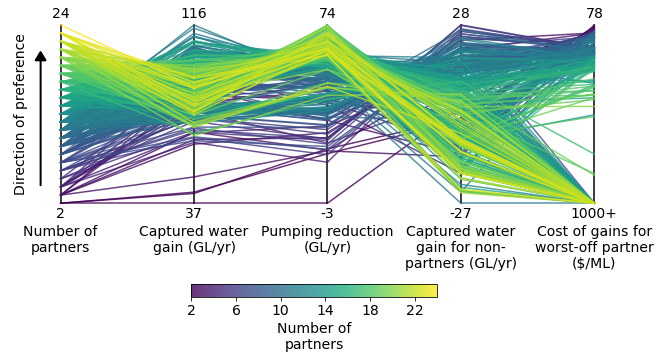

In [7]:
### basic parallel axis plot
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, 
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], 
                            colorbar_ticks_continuous=range(2,25,4),
                            save_fig_filename = f'{fig_dir}/paraxis1.png')

Here is an example where we flip the direction of preference to be "bottom" and switch the coloration and zorder to be based on column 3 rather than column 0. The zorder ranking is also switch to be descending rather than ascending.

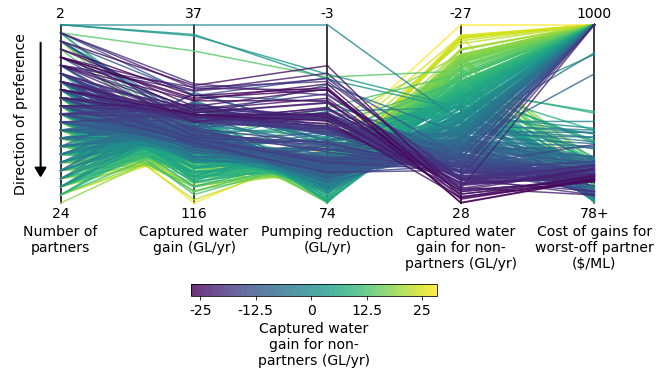

In [8]:
### flip direction of preference & color/order by axis 3 (note zero-indexing; Captured Water Gain for Non-partners)
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, 
                            color_by_continuous=3, ideal_direction='bottom',
                            zorder_by=3, zorder_direction = 'descending',
                            alpha_base = 0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], 
                            colorbar_ticks_continuous=[-25,-12.5,0,12.5,25],
                            save_fig_filename = f'{fig_dir}/paraxis2.png')

Now let's add some brushing. Brushing is the act of filtering out solutions that fail to meet certain satisficing criteria. In the figure below, I filter out all solutions that fail to meet one or more of these 3 criteria: (1) the number of partners is at least 16; (2) The Captured water gains for non-partners is non-negative; and (3) The cost of gains for the worst-off partner is less than $500/ML. These criterion are added in a straightforward way using the "brushing_dict" dictionary format, as demonstrated below. The function will automatically add grey boxes over the filtered-out region for each brushing criterion.

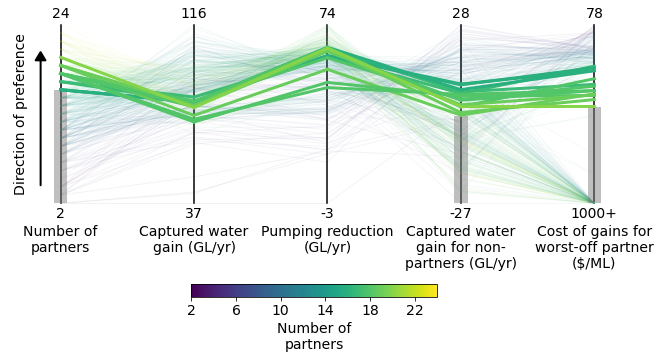

In [9]:
### basic parallel axis plot with brushing. Grey rectangles cover filtered-out solutions based on user-defined brushing criteria.
custom_parallel_coordinates(objs, columns_axes=objs.columns, axis_labels = axis_labels, 
                            color_by_continuous=0, zorder_by=0, ideal_direction='top',
                            alpha_base = 1, lw_base=3, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], 
                            colorbar_ticks_continuous=range(2,25,4),
                            brushing_dict = {0: (16, '>='), 3: (0, '>='), 4: (500, '<')},
                            save_fig_filename = f'{fig_dir}/paraxis3.png')

This function also has the ability to color solutions based on a categorical variable rather than a continuous palette. The following example defines a new categorical variable by binning the continuous cost variable into three discrete classes. It then defines a color dictionary that assigns a different color to each possible value of the categorical variable. The legend is automatically created based on the color dictionary.

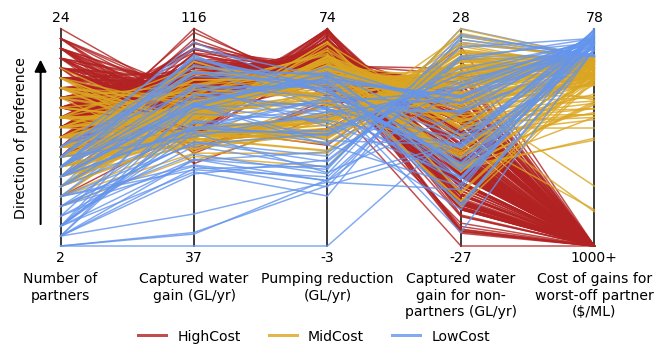

In [10]:
### Now color by a categorical variable that isnt one of the axes
color_dict_categorical = {'HighCost': 'firebrick', 'MidCost': 'goldenrod', 'LowCost': 'cornflowerblue'}
objs_with_categorical = objs.copy()
objs_with_categorical['Set'] = ['HighCost' if c>=1000 else 'MidCost' if c>=200 else 'LowCost' for c in objs['cog_wp_p90']]

custom_parallel_coordinates(objs_with_categorical, columns_axes=columns_axes, axis_labels = axis_labels, 
                            zorder_by=4, ideal_direction='top',
                            alpha_base=0.8, lw_base=1.5, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], 
                            colorbar_ticks_continuous=range(2,25,4),
                            color_by_categorical = 'Set', color_dict_categorical=color_dict_categorical,
                            save_fig_filename = f'{fig_dir}/paraxis4.png')

Finally, here is an example that combines brushing with categorical coloration. This shows that no LowCost or HighCost solutions are able to meet the given satisficing criteria.

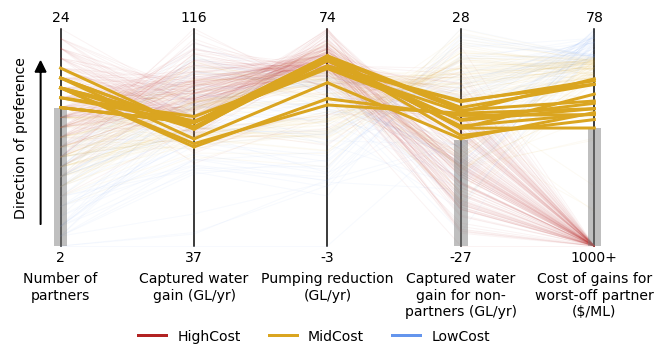

In [11]:
### Now color by a categorical variable that isnt one of the axes, with brushing
custom_parallel_coordinates(objs_with_categorical, columns_axes=columns_axes, axis_labels = axis_labels, 
                            zorder_by=4, ideal_direction='top',
                            alpha_base=1, lw_base=3, fontsize=fontsize, figsize=figsize,
                            minmaxs=['max','max','max','max','min'], 
                            colorbar_ticks_continuous=range(2,25,4),
                            color_by_categorical = 'Set', color_dict_categorical=color_dict_categorical,
                            brushing_dict = {0: (16, '>='), 3: (0, '>='), 4: (500, '<')},
                            save_fig_filename = f'{fig_dir}/paraxis5.png')

### Conclusion

I hope this serves as a useful baseline for other Reed Group members who regularly create custom parallel coordinates plots. It would be great to see others add to this over time as new use cases arise so that we can all benefit from improved flexibility & functionality and not have to regularly reinvent the wheel. If you have ideas to improve these functions or add new functionality, feel free to open a GitHub Issue or contribute directly to [this page](https://github.com/reedgroup/reedgroup.github.io/blob/main/docs/FigureLibrary/ParallelCoordinatesPlots.ipynb) in the Reed Group Lab Manual repository. 